<a href="https://colab.research.google.com/github/waltterval/coursera_tareas/blob/master/assignment2_vf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false; // disable scroll bar when displaying Folium map
}

<IPython.core.display.Javascript object>

# Assignment 2

Before working on this assignment please read these instructions fully. In the submission area, you will notice that you can click the link to **Preview the Grading** for each step of the assignment. This is the criteria that will be used for peer grading. Please familiarize yourself with the criteria before beginning the assignment.

The data for this assignment comes from a subset of The National Centers for Environmental Information (NCEI) [Global Historical Climatology Network daily (GHCNd)](https://www.ncei.noaa.gov/products/land-based-station/global-historical-climatology-network-daily) (GHCN-Daily). The GHCN-Daily is comprised of daily climate records from thousands of land surface stations across the globe - it's a wonderfully large dataset to play with! In particular, you will be asked to use data from the Ann Arbor Michigan location (my home!). and this is stored in the file: `assets/fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89.csv`

Each row in this datafile corresponds to a single observation from a weather station, and has the following variables:
* **id** : station identification code
* **date** : date in YYYY-MM-DD format (e.g. 2012-01-24 = January 24, 2012)
* **element** : indicator of element type
    * TMAX : Maximum temperature (tenths of degrees C)
    * TMIN : Minimum temperature (tenths of degrees C)
* **value** : data value for element (tenths of degrees C)

For this assignment, you must:

1. Read the documentation and familiarize yourself with the dataset, then write a python notebook which plots line graphs of the record high and record low temperatures by day of the year over the period 2005-2014. The area between the record high and record low temperatures for each day should be shaded.
2. Overlay a scatter of the 2015 data for any points (highs and lows) for which the ten year record (2005-2014) record high or record low was broken in 2015. (Based on the graph, do you think extreme weather is getting more frequent in 2015?)
3. Watch out for leap days (i.e. February 29th), it is reasonable to remove these points from the dataset for the purpose of this visualization.
4. Make the visual nice! Leverage principles from the first module in this course when developing your solution. Consider issues such as legends, labels, and chart junk.

I've written some steps I think would be good to go through, but there are other ways to solve this assignment so feel free to explore the pandas library! What I really want to see is an image that looks like this sketch I drew at my desk:

![](assets/chris_sketch.png)

In [ ]:
#  I'll be using the folium package to render the data into a map in Jupyter.

import folium
import pandas as pd

# get the location information for this dataset
df = pd.read_csv('assets/BinSize_d400.csv')
station_locations_by_hash = df[df['hash'] == 'fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89']

# get longitude and lattitude to plot
lons = station_locations_by_hash['LONGITUDE'].tolist()
lats = station_locations_by_hash['LATITUDE'].tolist()

# plot on a beautiful folium map
my_map = folium.Map(location = [lats[0], lons[0]], height = 500,  zoom_start = 9)
for lat, lon in zip(lats, lons):
    folium.Marker([lat, lon]).add_to(my_map)

# render map in Jupyter
display(my_map)

## Step 1
Load the dataset and transform the data into Celsius (refer to documentation) then extract all of the rows which have minimum or maximum temperatures.

__hint: when I did this step I had two DataFrame objects, each with ~80,000 entries in it__

In [ ]:
import pandas as pd
df = pd.read_csv('assets/fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89.csv')
df.head()

,ID,Date,Element,Data_Value
0,USW00094889,2014-11-12,TMAX,22
1,USC00208972,2009-04-29,TMIN,56
2,USC00200032,2008-05-26,TMAX,278
3,USC00205563,2005-11-11,TMAX,139
4,USC00200230,2014-02-27,TMAX,-106


In [ ]:
# In this code cell, transform the Data_Value column

# Filter on `Element` = 'TMAX'
df_max = df[df['Element'] == 'TMAX'].copy()

# Filter on `Element` = 'TMIN'
df_min = df[df['Element'] == 'TMIN'].copy()

# Divide `Data_Value` by 10
df_max['Data_Value'] = df_max['Data_Value'] / 10
df_min['Data_Value'] = df_min['Data_Value'] / 10

## Step 2
In order to visualize the data we would plot the min and max data for each day of the year between the years 2005 and 2014 across all weather stations. But we also need to find out when the min or max temperature in 2015 falls below the min or rises above the max for the previous decade.

If you did step 1 you have two Series objects with min and max times for the years 2005 through 2015. You can use Pandas `groupby` to create max and min temperature Series objects across all weather stations for each day of these years, and you can deal with the records for February 29 (the leap year) by dropping them.

__hint: when I finished this step, I had two DataFrame objects, each with exactly 4015 observations in them__

In [ ]:
# create a DataFrame of maximum temperature by date
# Convert `Date` to datetime
df_max['Date'] = pd.to_datetime(df_max['Date'])

# Filter out February 29th
df_max = df_max[~((df_max['Date'].dt.month == 2) & (df_max['Date'].dt.day == 29))]

# Group by `Date` and find the maximum temperature for each date
df_max_temp_by_date = df_max.groupby('Date')['Data_Value'].max()

# create a DataFrame of minimum temperatures by date
# Convert `Date` to datetime
df_min['Date'] = pd.to_datetime(df_min['Date'])
# Filter out February 29th
df_min = df_min[~((df_min['Date'].dt.month == 2) & (df_min['Date'].dt.day == 29))]
# Group by `Date` and find the minimum temperature for each date
df_min_temp_by_date = df_min.groupby('Date')['Data_Value'].min()

## Step 3
Now that you have grouped the daily max and min temperatures for each day of the years 2005 through 2015, you can separate out the data for 2015. Then you can use the Pandas `groupby` function to find the max and min of the temperature data for each __day of the year__ for the 2005-2014 data.

__hint: at the end of this step I had two DataFrames, one of maximum and the other of minimum values, which each had 365 observations in them. I also had another pair of similar DataFrames but only for the year 2015.__

In [ ]:
# calculate the minimum and maximum values for the day of the year for 2005 through 2014
# Filter for 2005-2014
df_max_temp_2005_2014 = df_max_temp_by_date[df_max_temp_by_date.index.year != 2015]
df_min_temp_2005_2014 = df_min_temp_by_date[df_min_temp_by_date.index.year != 2015]
# Convert to dataframes
df_max_temp_2005_2014 = pd.DataFrame(df_max_temp_2005_2014)
df_min_temp_2005_2014 = pd.DataFrame(df_min_temp_2005_2014)
# Create Column Month
df_max_temp_2005_2014['Month'] = df_max_temp_2005_2014.index.month
df_min_temp_2005_2014['Month'] = df_min_temp_2005_2014.index.month
# Create Column Day
df_max_temp_2005_2014['Day'] = df_max_temp_2005_2014.index.day
df_min_temp_2005_2014['Day'] = df_min_temp_2005_2014.index.day
# Group by month and day
df_max_temp_agg = df_max_temp_2005_2014.groupby(['Month', 'Day']).max().reset_index()
df_min_temp_agg = df_min_temp_2005_2014.groupby(['Month', 'Day']).min().reset_index()

# calculate the minimum and maximum values for the years 2015
# Filter for 2015
df_max_temp_2015 = df_max_temp_by_date[df_max_temp_by_date.index.year == 2015]
df_min_temp_2015 = df_min_temp_by_date[df_min_temp_by_date.index.year == 2015]
# Convert to dataframes
df_max_temp_2015 = pd.DataFrame(df_max_temp_2015)
df_min_temp_2015 = pd.DataFrame(df_min_temp_2015)
# Create column Month
df_max_temp_2015['Month'] = df_max_temp_2015.index.month
df_min_temp_2015['Month'] = df_min_temp_2015.index.month
# Create column Day
df_max_temp_2015['Day'] = df_max_temp_2015.index.day
df_min_temp_2015['Day'] = df_min_temp_2015.index.day

df_max_temp_2015 = df_max_temp_2015.reset_index()
df_min_temp_2015 = df_min_temp_2015.reset_index()

record_high = df_max_temp_2015[df_max_temp_2015['Data_Value'] > df_max_temp_agg['Data_Value']]
record_low = df_min_temp_2015[df_min_temp_2015['Data_Value'] < df_min_temp_agg['Data_Value']]

## Step 4
Now it's time to plot! You need to explore matplotlib in order to plot line graphs of the min and max temperatures for the years 2005 through 2014 and to scatter plot __only__ the daily 2015 temperatures that exceeded those values.

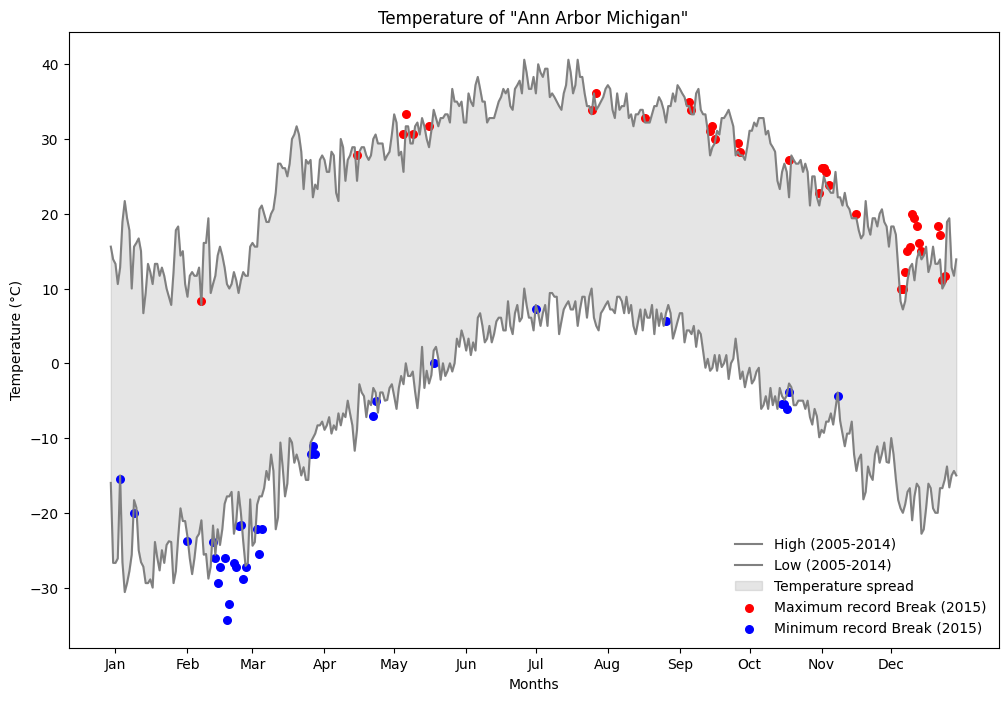

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
# Convert 1 and -1 to Timedelta objects
one_day = pd.to_timedelta("1 days")
minus_one_day = pd.to_timedelta("-1 days")

# Add 1 day to the start of each month in the date range from '2015-01-01' to '2015-12-31' with a monthly frequency
xticks_str = (pd.date_range('2015-01-01', '2015-12-31', freq='MS') + one_day).strftime('%-j').tolist()

# Convert xticks_str to a list of integers
xticks = [int(x) for x in xticks_str]

# Convert xticks to datetime objects and format them as abbreviated month names
xticks_labels = pd.to_datetime(xticks, format='%j').strftime('%b')

# Set up the plot
plt.figure(figsize=(12, 8))

# Plot the 2005-2014 max and min temperatures on the axes
plt.plot(df_max_temp_agg.index, df_max_temp_agg['Data_Value'], color='grey')
plt.plot(df_min_temp_agg.index, df_min_temp_agg['Data_Value'], color='grey')

# Shade the area between the max and min temperature lines with a grey color and an alpha of 0.2
plt.fill_between(df_max_temp_agg.index, df_max_temp_agg['Data_Value'], df_min_temp_agg['Data_Value'],
                 color='grey', alpha=0.2)

# Create scatter plots for the 2015 record-breaking max and min temperatures using the index column for the x-axis
plt.scatter(record_high.index, record_high['Data_Value'], color='red', marker='o', s=30)
plt.scatter(record_low.index, record_low['Data_Value'], color='blue', marker='o', s=30)
plt.xticks(xticks, xticks_labels)
plt.legend(loc=4,labels = ['High (2005-2014)', 'Low (2005-2014)', 'Temperature spread', 'Maximum record Break (2015)', 'Minimum record Break (2015)'], frameon = False)
plt.xlabel('Months')
plt.ylabel('Temperature (°C)')
plt.title(r'Temperature of "Ann Arbor Michigan"');